# Masking grids

In [1]:
import os

import geopandas as gpd

import polartoolkit as ptk

In [2]:
# set default to northern hemisphere for this notebook
os.environ["POLARTOOLKIT_HEMISPHERE"] = "north"

In [3]:
# fetch a grid
grid = ptk.fetch.etopo(
    layer="surface",
    region=ptk.regions.greenland,
)

## Mask with a shapefile

In [4]:
# fetch a shapefile
shapefile = ptk.fetch.groundingline(version="BAS")

# load the shapefile
groundingline = gpd.read_file(shapefile)

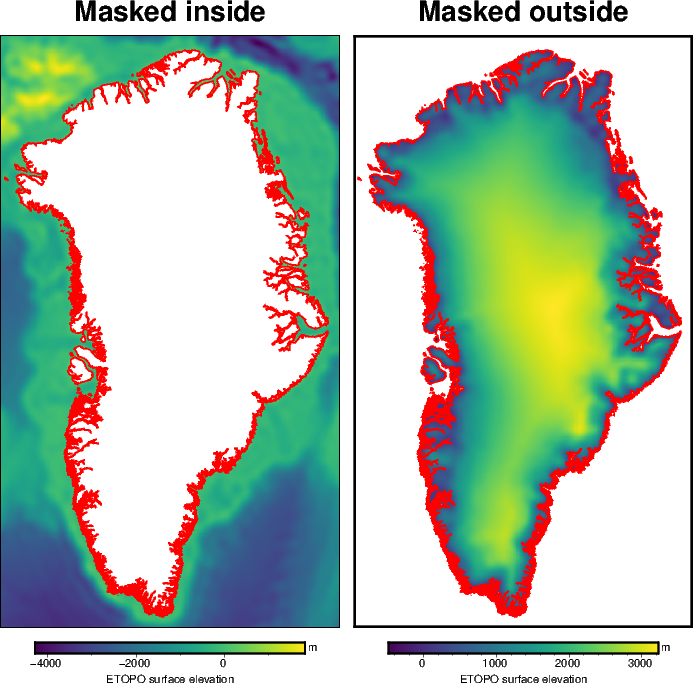

In [5]:
# mask the inside region
masked_inside = ptk.mask_from_shapefile(
    shapefile=groundingline,
    grid=grid,
    masked=True,
)

# mask the outside region
masked_outside = ptk.mask_from_shapefile(
    shapefile=groundingline,
    grid=grid,
    masked=True,
    invert=False,
)

# plot the inside-masked grid
fig = ptk.plot_grid(
    masked_inside,
    title="Masked inside",
    cbar_label="ETOPO surface elevation",
    cbar_unit="m",
)
# plot the shapefile
fig.plot(groundingline, pen=".8p,red")

# plot the outside-masked grid
fig = ptk.plot_grid(
    masked_outside,
    title="Masked outside",
    cbar_label="ETOPO surface elevation",
    cbar_unit="m",
    fig=fig,
    origin_shift="x",
)
# plot the shapefile
fig.plot(groundingline, pen=".8p,red")


# show the plot
fig.show(dpi=100)

## Interactively mask

In [6]:
polygon = ptk.draw_region()

Label(value='')

Map(center=[70.0, -45.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [9]:
polygon

[[[-42.378063, 72.363926],
  [-46.968767, 71.98377],
  [-47.5952, 70.151241],
  [-47.216462, 69.202262],
  [-45, 68.85142],
  [-41.05653, 68.527433],
  [-39.970926, 68.88165],
  [-38.361365, 69.7628],
  [-40.049297, 70.467213],
  [-41.377801, 71.016679],
  [-41.405596, 71.460268],
  [-41.025837, 72.136598]]]

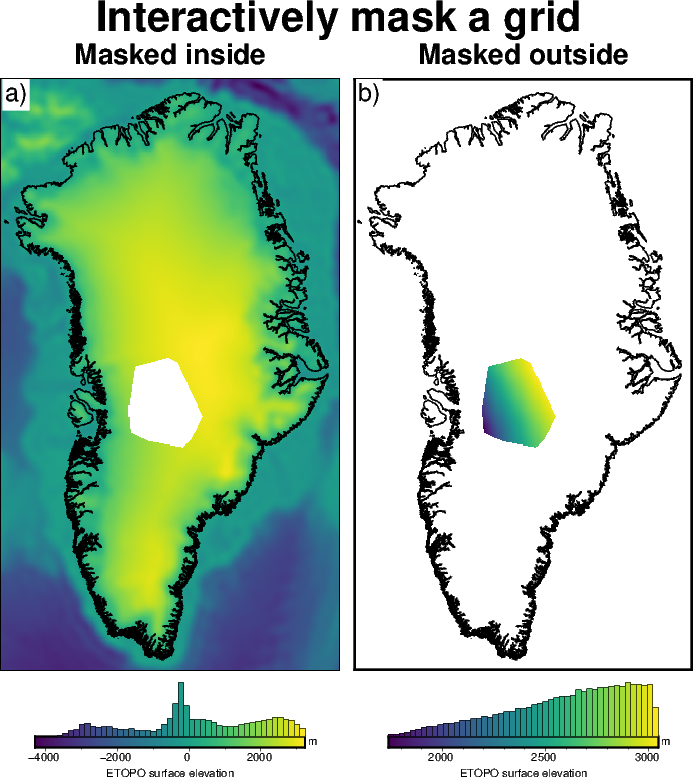

In [10]:
masked_outside = ptk.mask_from_polygon(
    polygon,
    grid=grid,
)
masked_inside = ptk.mask_from_polygon(
    polygon,
    grid=grid,
    invert=True,
)

# show results in a plot
fig = ptk.subplots(
    [masked_inside, masked_outside],
    coast=True,
    inset=False,
    fig_title="Interactively mask a grid",
    titles=["Masked inside", "Masked outside"],
    cbar_label="ETOPO surface elevation",
    cbar_unit="m",
    hist=True,
)

fig.show(dpi=100)

## Using polygons / shapefiles in other functions
Shapefiles or interactively drawn polygons can be passed to several other functions as inputs. A few of these options are shown below.

### Get min / max values only within mask

In [11]:
# get min and max of the full grid
min_max = ptk.get_min_max(grid)

print(f"full grid min / max: {min_max[0]} / {min_max[1]}")

full grid min / max: -4278.2353515625 / 3226.35986328125


In [12]:
# Convert the polygon to a shapefile
shapefile = ptk.polygon_to_shapefile(polygon)
shapefile

,geometry
0,"POLYGON ((88064.01 -1923071.962, -67583.991 -1..."


Get the min and max of just the part of the grid inside the polygon.

In [13]:
min_max = ptk.get_min_max(grid, shapefile=shapefile)

print(f"full grid min / max: {min_max[0]} / {min_max[1]}")

full grid min / max: 1736.755126953125 / 3034.247314453125


The shapefile can also be passed through any of the plotting functions to the `set_cmap` function, to create a colormap based on the values only within the shapefile. This is useful of extreme values outside your area of interest are skewing your colorscale. 

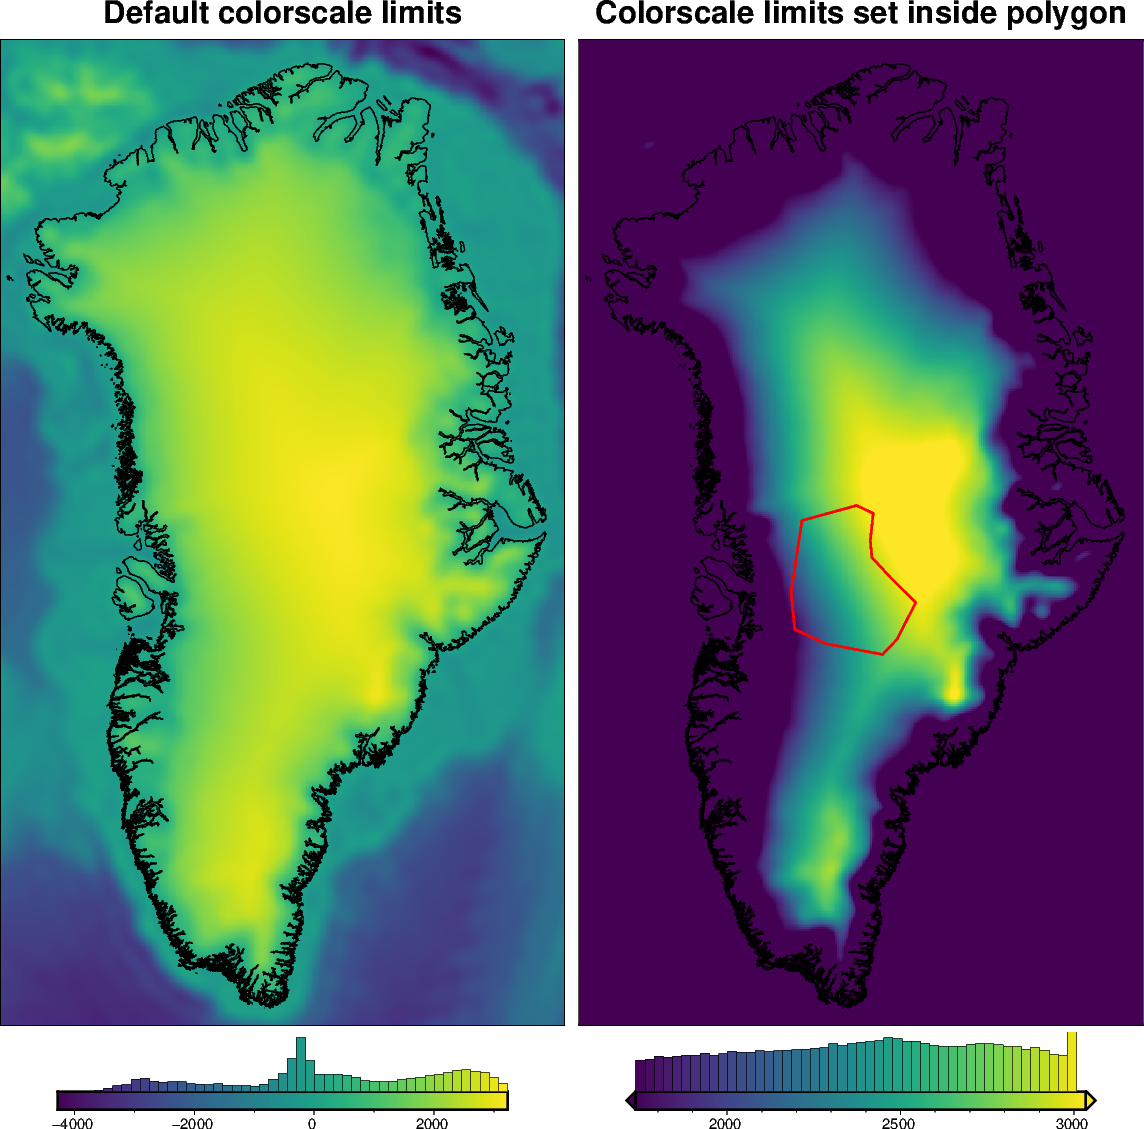

In [14]:
# plot the grid with default colorscale limits
fig = ptk.plot_grid(
    grid,
    hist=True,
    title="Default colorscale limits",
    fig_height=25,
    coast=True,
)

# plot the grid again with colorscale limits set to min and max within the polygon
fig = ptk.plot_grid(
    grid,
    hist=True,
    shapefile=shapefile,
    coast=True,
    fig=fig,
    origin_shift="x",
    title="Colorscale limits set inside polygon",
)
fig.plot(
    shapefile,
    pen="1.5p,red",
)
fig.show(dpi=100)

## Extract points within shapefile
Given a pandas DataFrame of point data, we can extract just the points which are inside of the shapefile.

In [15]:
# get a shapefile of Antarctica's Getz Ice Shelf drainage basin
fname = ptk.fetch.antarctic_boundaries(version="Basins_Antarctica")
ice_boundaries = gpd.read_file(fname)
getz_basin = ice_boundaries[ice_boundaries.NAME == "Getz"]
getz_basin

,NAME,Regions,Subregions,TYPE,Asso_Shelf,geometry
145,Getz,West,F-G,GR,Getz,"POLYGON ((-1126366.826 -1113537.613, -1126366...."


In [16]:
# get some Moho elevation points for Antarctica
df = ptk.fetch.moho(version="an-2015-points")

# subset points inside the Getz basin
getz_df = ptk.points_inside_shapefile(df, getz_basin, epsg="3031")
getz_df

,Name,lon,lat,crustal_thickness,moho_elevation,Sources,x,y,geometry
162,ST09,-128.4734,-76.5309,31740.0,-29500.0,9,-1.150824e+06,-914534.401027,POINT (-1150823.575 -914534.401)
163,ST10,-129.7489,-75.8143,29830.0,-28100.0,9,-1.190889e+06,-990413.595610,POINT (-1190889.417 -990413.596)


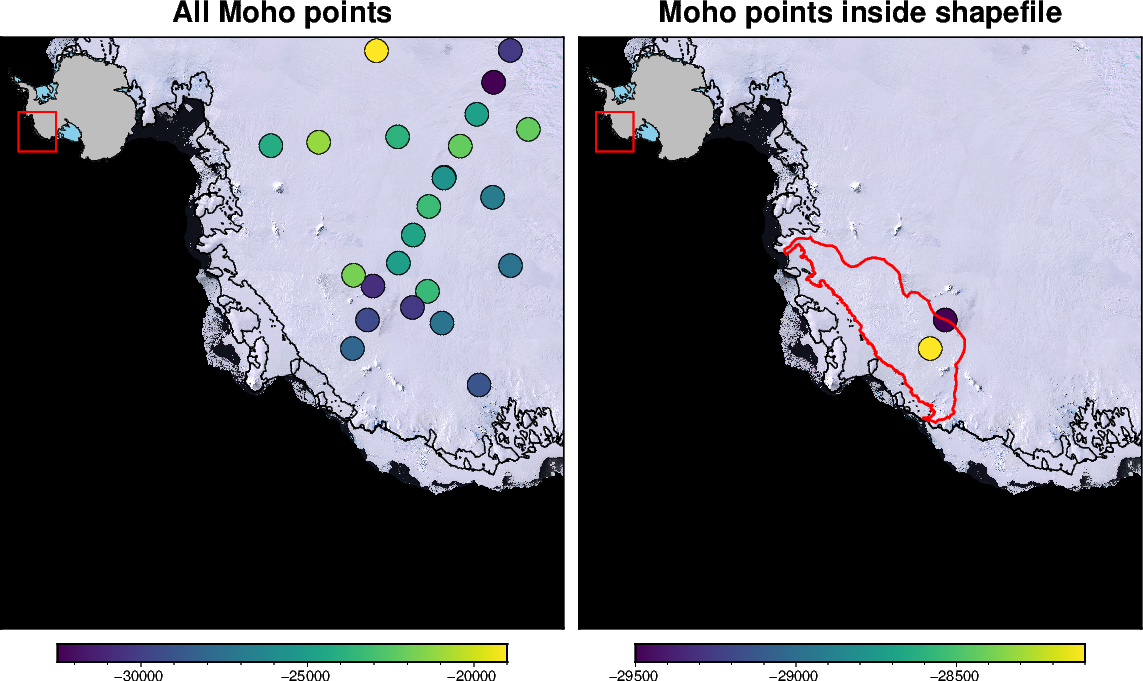

In [17]:
fig = ptk.basemap(
    region=ptk.alter_region(ptk.regions.getz_ice_shelf, zoom=-500e3),
    coast=True,
    inset=True,
    points=df,
    points_fill="moho_elevation",
    points_style="c.6c",
    points_pen=".2p,black",
    epsg="3031",
    title="All Moho points",
    imagery_basemap=True,
)

fig = ptk.basemap(
    coast=True,
    inset=True,
    points=getz_df,
    points_fill="moho_elevation",
    points_style="c.6c",
    points_pen=".2p,black",
    fig=fig,
    origin_shift="x",
    epsg="3031",
    title="Moho points inside shapefile",
    imagery_basemap=True,
)

fig.plot(
    getz_basin,
    pen="1.5p,red",
)

fig.show(dpi=100)

## Make custom shapefile in QGIS

QGIS, especially with the [Quantarctica](https://www.npolar.no/quantarctica/#toggle-id-2) and [QGreenland](https://qgreenland.org/) packages, is an easy way to interactively make a custom shapefile. This can then be used with `polartoolkit` to sample data along the file.

To make the shapefile in QGIS:
*  Layer -> Create Layer -> New Shapefile Layer
* For `Geometry Type`, select `Polygon`
* Select the appropriate EPSG coordinate reference system
* Save to the same directory as your python file you want to work with.